# Segmentation de clients d’un site de commerce

## 1. Compréhension de la problématique métier
## 2. Description de l’ensemble de données
## 3. Exploratory Data Analysis
## 4. Analyse RFM pour la segmentation des clients
## 5. Modélisation K-Means Clustering
## 6. Classification ascendante hiérarchique
## 7. Modélisation DBSCAN Clustering
## 8. Segmentation
## 9. Stabilité temporelle de la segmentation

## 1. Compréhension de la problématique métier

Olist souhaite que nous fournissions à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Notre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

## 2. Description de l’ensemble de données

Il s’agit d’un ensemble de données publiques de commerce électronique brésilien sur les commandes passées sur Olist Store. L’ensemble de données contient des informations sur 100 000 commandes de 2016 à 2018 effectuées sur plusieurs marchés au Brésil. Ses fonctionnalités permettent de visualiser une commande à partir de plusieurs dimensions: de l’état de la commande, du prix, des performances de paiement et de fret à l’emplacement du client, aux attributs du produit et enfin aux avis écrits par les clients. Nous avons également publié un ensemble de données de géolocalisation qui relie les codes postaux brésiliens aux coordonnées GPS lat/lng.

Il s’agit de données commerciales réelles, elles ont été anonymisées et les références aux entreprises et partenaires dans le texte de la revue ont été remplacées par les noms des grandes maisons de Game of Thrones.

### 2.1. Contexte

Cet ensemble de données a été généreusement fourni par Olist, le plus grand magasin des marchés brésiliens. Olist connecte les petites entreprises de tout le Brésil à des canaux sans tracas et avec un seul contrat. Ces marchands peuvent vendre leurs produits via la boutique Olist et les expédier directement aux clients en utilisant les partenaires logistiques Olist.


Une fois qu’un client a acheté le produit sur Olist Store, un vendeur est averti pour exécuter cette commande. Une fois que le client reçoit le produit, ou que la date de livraison estimée est due, le client reçoit une enquête de satisfaction par e-mail où il peut donner une note pour l’expérience d’achat et écrire quelques commentaires.

### 2.2.  Importation des librairies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 

### 2.3. Importation des datasets

In [2]:
df_item = pd.read_csv("olist_order_items_dataset.csv")
df_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("olist_orders_dataset.csv")
df_products = pd.read_csv("olist_products_dataset.csv")
df_geolocation = pd.read_csv("olist_geolocation_dataset.csv")
df_sellers = pd.read_csv("olist_sellers_dataset.csv")
df_order_pay = pd.read_csv("olist_order_payments_dataset.csv")
df_customers = pd.read_csv("olist_customers_dataset.csv")
df_category = pd.read_csv("product_category_name_translation.csv")

### 2.4. Fusion des datasets

In [3]:
df_train = df_orders.merge(df_item, on='order_id', how='left')
df_train = df_train.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_order_pay, on='order_id')
df_train = df_train.merge(df_reviews, on='order_id', how='outer')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_customers, on='customer_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')

In [4]:
print(df_train.shape)

(141532, 43)


#### 2.4.1. Fonction pour explorer nos données

In [5]:
def resutable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(
            stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

 
def cross_heatmap(df, cols, normalize=False, values=None, aggfunc=None):
    temp = cols
    cm = sns.light_palette("green", as_cmap=True)
    return pd.crosstab(df[temp[0]], df[temp[1]], 
                       normalize=normalize,
                       values=values,
                       aggfunc=aggfunc).style.background_gradient(cmap = cm)

In [6]:
resutable(df_train)

Dataset Shape: (141532, 43)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,order_id,object,1,99441,e481f51cbdc54678b7cc49136f2d6af7,e481f51cbdc54678b7cc49136f2d6af7,e481f51cbdc54678b7cc49136f2d6af7,15.79
1,customer_id,object,1,99441,9ef432eb6251297304e76186b10a928d,9ef432eb6251297304e76186b10a928d,9ef432eb6251297304e76186b10a928d,15.79
2,order_status,object,2,8,delivered,delivered,delivered,0.29
3,order_purchase_timestamp,object,2,98874,2017-10-02 10:56:33,2017-10-02 10:56:33,2017-10-02 10:56:33,15.78
4,order_approved_at,object,277,90732,2017-10-02 11:07:15,2017-10-02 11:07:15,2017-10-02 11:07:15,15.64
5,order_delivered_carrier_date,object,2640,81017,2017-10-04 19:55:00,2017-10-04 19:55:00,2017-10-04 19:55:00,15.41
6,order_delivered_customer_date,object,4869,95663,2017-10-10 21:25:13,2017-10-10 21:25:13,2017-10-10 21:25:13,15.77
7,order_estimated_delivery_date,object,2,458,2017-10-18 00:00:00,2017-10-18 00:00:00,2017-10-18 00:00:00,8.45
8,order_item_id,float64,1149,21,1.0,1.0,1.0,0.72
9,product_id,object,1149,32951,87285b34884572647811a353c7ac498a,87285b34884572647811a353c7ac498a,87285b34884572647811a353c7ac498a,13.29


In [7]:
df_train.dtypes.value_counts()

object     24
float64    19
dtype: int64

Maintenant, nous avons une certaine compréhension de la façon dont nos données sont.

#### 2.4.2. Trier les colonnes

Pour organiser le travail, je trirais des colomnes par type.

In [8]:
id_cols = ['order_id', 'seller_id', 'customer_id', 'order_item_id', 'product_id', 
           'review_id', 'customer_unique_id', 'seller_zip_code_prefix']

#categorical columns
cat_cols = df_train.nunique()[df_train.nunique() <= 27].keys().tolist()
# cat_cols = [x for x in cat_cols if x not in target_col]

#numerical columns
num_cols = [x for x in df_train.columns if x not in cat_cols + id_cols]

#Binary columns with 2 values
bin_cols = df_train.nunique()[df_train.nunique() == 2].keys().tolist()

#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]
print(cat_cols)
print(num_cols)
print(bin_cols)
print(multi_cols)

['order_status', 'order_item_id', 'payment_type_x', 'payment_installments_x', 'payment_type_y', 'payment_installments_y', 'review_score', 'product_photos_qty', 'customer_state', 'seller_state']
['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date', 'price', 'freight_value', 'payment_sequential_x', 'payment_value_x', 'payment_sequential_y', 'payment_value_y', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'customer_zip_code_prefix', 'customer_city', 'seller_city']
[]
['order_status', 'order_item_id', 'payment_type_x', 'payment_installments_x', 'payment_type_y', 'payment_installments_y', 'review_score', 'product_photos_qty', 'customer_state', 'seller_state']


## 3. Exploratory Data Analysis


### 3.1. Destribution des prix

Pour analyser les données par un biais financier, je vais commencer à comprendre les distributions de prix

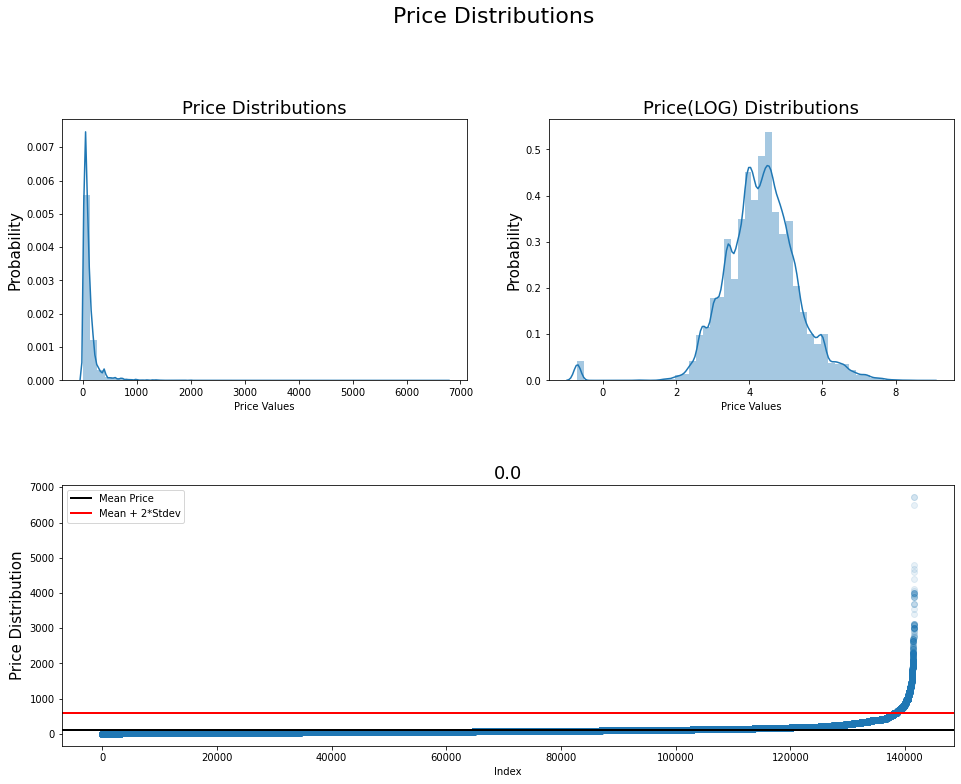

In [9]:
df_train['price'].fillna(-1, inplace=True)

plt.figure(figsize=(16,12))
plt.suptitle('Price Distributions', fontsize=22)
plt.subplot(221)
g = sns.distplot(df_train['price'])
g.set_title("Price Distributions", fontsize=18)
g.set_xlabel("Price Values")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(df_train['price']+1.5))
g1.set_title("Price(LOG) Distributions", fontsize=18)
g1.set_xlabel("Price Values")
g1.set_ylabel("Probability", fontsize=15)

plt.subplot(212)
g4 = plt.scatter(range(df_train.shape[0]),
                 np.sort(df_train['price'].values), 
                 alpha=.1)
g4 = plt.title(0., fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Price Distribution", fontsize=15)
g4 = plt.axhline(df_train[df_train['price'] != -1]['price'].mean(), color='black', 
           label='Mean Price', linewidth=2)
g4 = plt.axhline(df_train[df_train['price'] != -1]['price'].mean() + (2.5*df_train[df_train['price'] != -1]['price'].std()),
                 color='red', 
           label='Mean + 2*Stdev', linewidth=2)
g4 = plt.legend()

plt.subplots_adjust(hspace = 0.4, top = 0.85)
plt.show()

Cela nous donne une vision de la répartition des prix. La valeur moyenne est: BRL 120,65
L’écart-type est: BRL 184,11.Dans le graphique, j’ai défini comme valeurs aberrantes tous les prix des produits qui franchissent la limite de La moyenne (120,65) + 2,5 fois le Stdev (184,11).
La valeur aberrante liée à la définition est BRL 580.92

### 3.2. Type de paiement

In [10]:
df_train['price_log'] = np.log(df_train['price'] + 1.5)

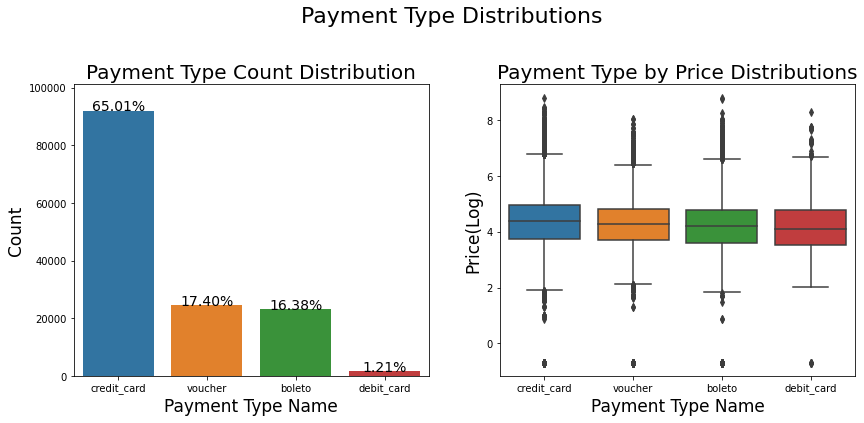

In [11]:
total = len(df_train)

plt.figure(figsize=(14,6))

plt.suptitle('Payment Type Distributions', fontsize=22)

plt.subplot(121)
g = sns.countplot(x='payment_type_x',
                  data=df_train[df_train['payment_type_x'] != 'not_defined'])
g.set_title("Payment Type Count Distribution", fontsize=20)
g.set_xlabel("Payment Type Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)

sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.1)

plt.subplot(122)
g = sns.boxplot(x='payment_type_x', 
                y='price_log',
                data = df_train[df_train['payment_type_x'] != 'not_defined'])
g.set_title("Payment Type by Price Distributions", fontsize=20)
g.set_xlabel("Payment Type Name", fontsize=17)
g.set_ylabel("Price(Log)", fontsize=17)

plt.subplots_adjust(hspace = 0.5, top = 0.8)

plt.show()

Plus de 65.01% de toutes les ventes sont le type de paiement par carte de crédit.
Le deuxième type de paiement plus courant est le voucher(bon d'échange) avec 17,4%.
Le troisième type de paiement le plus courant est « boleto » (bordereau de paiement) avec près de 16.38%.Nous avons 1.21% de paiements par carte de débit.

### 3.3. Les variables des états

Je vais explorer les états  des clients et des vendeurs.
Donc, la répartition des prix et des valeurs de fret entre les États.

#### 3.3.1. Les états des clients

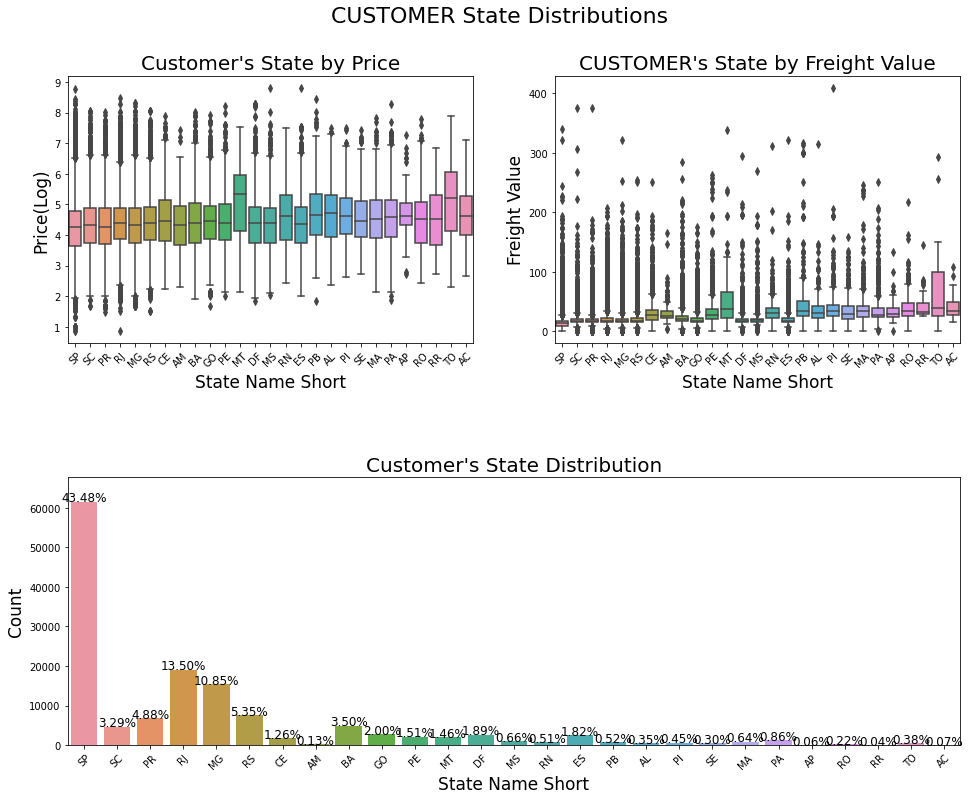

In [12]:
plt.figure(figsize=(16,12))

plt.suptitle('CUSTOMER State Distributions', fontsize=22)

plt.subplot(212)

g = sns.countplot(x='customer_state', data=df_train, orient='h')
g.set_title("Customer's State Distribution", fontsize=20)
g.set_xlabel("State Name Short", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.1)

plt.subplot(221)
g2 = sns.boxplot(x='customer_state', y='price_log', 
                 data=df_train[df_train['price'] != -1])
g2.set_title("Customer's State by Price", fontsize=20)
g2.set_xlabel("State Name Short", fontsize=17)
g2.set_ylabel("Price(Log)", fontsize=17)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)


plt.subplot(222)
g3 = sns.boxplot(x='customer_state', y='freight_value', 
                 data=df_train[df_train['price'] != -1])
g3.set_title("CUSTOMER's State by Freight Value", fontsize=20)
g3.set_xlabel("State Name Short", fontsize=17)
g3.set_ylabel("Freight Value", fontsize=17)
g3.set_xticklabels(g3.get_xticklabels(),rotation=45)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

plt.show()


Nous pouvons voir que les états le plus courant des clients est SP (43.48%), suivi de RJ (13,50%) et MG (10.85%).
Tous ces états sont de la région sud-est du Brésil. En outre, nous avons de nombreuses ventes à RS, PR, SC.

#### 3.3.2. Les états des vendeurs

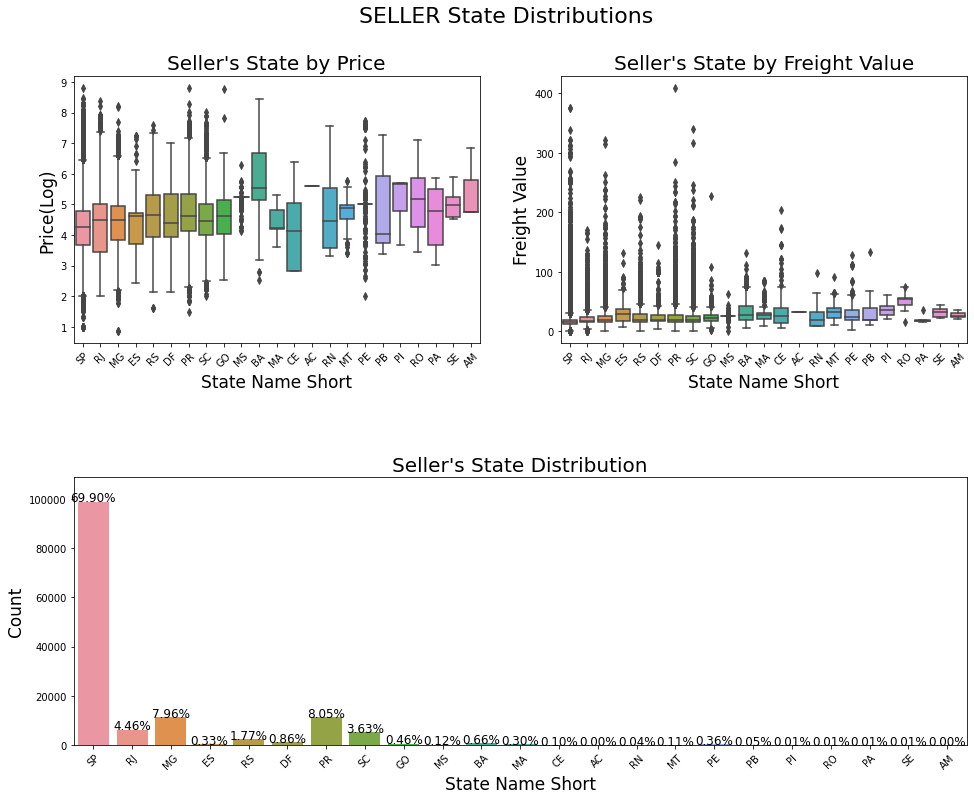

In [13]:
plt.figure(figsize=(16,12))

plt.suptitle('SELLER State Distributions', fontsize=22)

plt.subplot(212)
g = sns.countplot(x='seller_state', data=df_train, orient='h')
g.set_title("Seller's State Distribution", fontsize=20)
g.set_xlabel("State Name Short", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.1)

plt.subplot(221)
g2 = sns.boxplot(x='seller_state', y='price_log', 
                 data=df_train[df_train['price'] != -1])
g2.set_title("Seller's State by Price", fontsize=20)
g2.set_xlabel("State Name Short", fontsize=17)
g2.set_ylabel("Price(Log)", fontsize=17)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.subplot(222)
g3 = sns.boxplot(x='seller_state', y='freight_value', 
                 data=df_train[df_train['price'] != -1])
g3.set_title("Seller's State by Freight Value", fontsize=20)
g3.set_xlabel("State Name Short", fontsize=17)
g3.set_ylabel("Freight Value", fontsize=17)
g3.set_xticklabels(g3.get_xticklabels(),rotation=45)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

plt.show()

Contrairement à ce que nous avons vu dans les États clients, les vendeurs ont près de 70% des vendeurs de produits vendus à partir de SP, suivis de MG et PR.

#### 3.3.3. Fret moyen par États

L’objectif est d’obtenir la valeur moyenne lorsque le vendeur est de l’état X et le client de l’état Y.

Je ne sélectionnerai que les états les plus fréquents pour une meilleure vision

In [14]:
# Seting regions
sudeste = ['SP', 'RJ', 'ES','MG']
nordeste= ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
norte =  ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
centro_oeste = ['MT', 'GO', 'MS' ,'DF' ]
sul = ['SC', 'RS', 'PR']

df_train.loc[df_train['customer_state'].isin(sudeste), 'cust_Region'] = 'Southeast'
df_train.loc[df_train['customer_state'].isin(nordeste), 'cust_Region'] = 'Northeast'
df_train.loc[df_train['customer_state'].isin(norte), 'cust_Region'] = 'North'
df_train.loc[df_train['customer_state'].isin(centro_oeste), 'cust_Region'] = 'Midwest'
df_train.loc[df_train['customer_state'].isin(sul), 'cust_Region'] = 'South'

#### 2.3.3.1. Valeur de fret moyenne de l’État aux régions

In [15]:
cross_heatmap(df_train[df_train['price'] != -1], ['seller_state', 'cust_Region'], 
              values=df_train[df_train['price'] != -1]['freight_value'], aggfunc='mean')

cust_Region,Midwest,North,Northeast,South,Southeast
seller_state,,,,,
AC,nan,nan,nan,nan,32.840000
AM,nan,nan,28.255000,nan,25.290000
BA,30.023542,46.290476,20.705510,52.389837,36.057633
CE,65.456667,85.614000,22.501014,51.445556,45.597885
DF,13.077813,92.927023,27.452250,26.698750,19.631597
ES,36.895833,68.896250,26.922091,39.894510,28.378363
GO,14.686705,26.750385,33.369841,31.938393,24.239027
MA,27.150192,28.859000,19.299059,42.660652,31.822222
MG,26.080317,41.458717,33.550638,31.687135,21.409577


Les vendeurs de SP ont une moyenne de fret plus faible vers toutes les régions.
Les vendeurs CE ont une valeur moyenne élevée
On peut voir que les vendeurs du sud-est pourraient avoir un meilleur avantage concurrentiel.

#### 3.3.4. Order Item Id

Cette colonne correspond au total des articles achetés.

In [16]:
df_train['ord_new'] = df_train['order_item_id'].copy()

df_train.loc[df_train['order_item_id'].isin([7,8,9,10]), 'ord_new'] = '7 to 10'
df_train.loc[(df_train['order_item_id'] > 10), 'ord_new'] = '10 to 20'

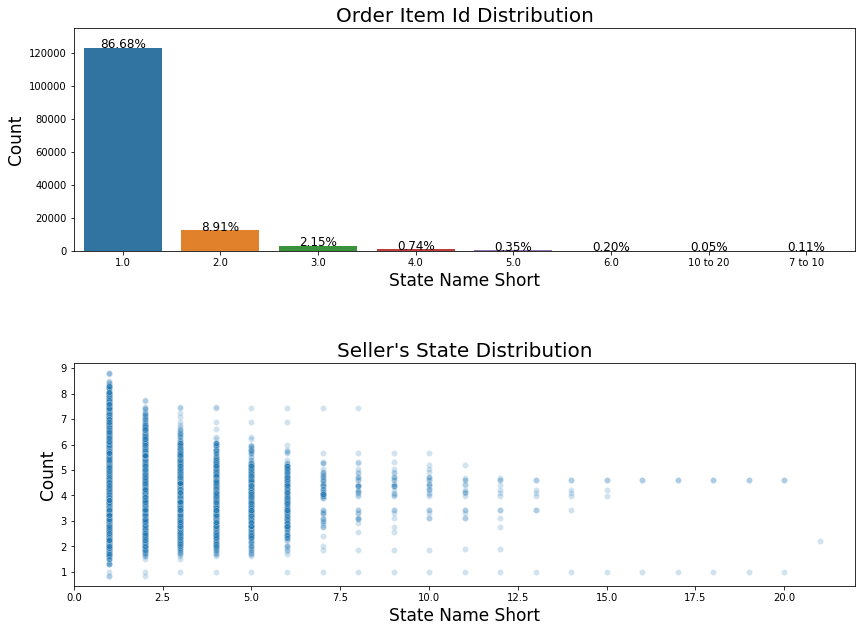

In [17]:
plt.figure(figsize=(14,10))

plt.subplot(211)
g = sns.countplot(x='ord_new', data=df_train)
g.set_title("Order Item Id Distribution", fontsize=20)
g.set_xlabel("State Name Short", fontsize=17)
g.set_ylabel("Count", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.1)

plt.subplot(212)
g1 = sns.scatterplot(x='order_item_id', y='price_log',
                     data=df_train, alpha=.2)
g1.set_title("Seller's State Distribution", fontsize=20)
g1.set_xlabel("State Name Short", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

plt.show()


Les 86,68% des articles commandés sont d’un seul article.

#### 3.3.5. Nombre total d’articles par note d’évaluation

In [18]:
round(pd.crosstab(df_train['order_item_id'], df_train['review_score'], normalize='index') *100,2)[:12].T

order_item_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
review_score,,,,,,,,,,,,
1.0,11.76,20.71,20.87,27.99,29.53,32.73,46.97,41.67,50.00,52.0,47.06,50.00
2.0,3.18,6.12,5.59,6.18,6.11,3.60,3.03,0.00,0.00,0.0,0.00,0.00
3.0,7.96,8.37,8.22,9.85,11.00,13.67,12.12,13.89,14.29,16.0,17.65,8.33
4.0,19.20,16.19,14.45,15.44,15.68,14.75,13.64,19.44,17.86,12.0,17.65,16.67
5.0,57.90,48.62,50.87,40.54,37.68,35.25,24.24,25.00,17.86,20.0,17.65,25.00


Nous pouvons voir que les commandes avec peu de quantités ont les review_score les plus élevés

##### 3.3.6. Suppression des colonnes product_id, seller_id, review_id

In [19]:
df_train.drop(['product_id', 'seller_id', 'review_id'], axis=1, inplace=True)

In [20]:
df_train.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,shipping_limit_date,...,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,price_log,cust_Region,ord_new
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,2017-10-06 11:07:15,...,7c396fd4830fd04220f754e42b4e5bff,3149.0,sao paulo,SP,9350.0,maua,SP,3.44967,Southeast,1.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,2017-10-06 11:07:15,...,7c396fd4830fd04220f754e42b4e5bff,3149.0,sao paulo,SP,9350.0,maua,SP,3.44967,Southeast,1.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,2017-10-06 11:07:15,...,7c396fd4830fd04220f754e42b4e5bff,3149.0,sao paulo,SP,9350.0,maua,SP,3.44967,Southeast,1.0
3,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,2017-10-06 11:07:15,...,7c396fd4830fd04220f754e42b4e5bff,3149.0,sao paulo,SP,9350.0,maua,SP,3.44967,Southeast,1.0
4,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,2017-10-06 11:07:15,...,7c396fd4830fd04220f754e42b4e5bff,3149.0,sao paulo,SP,9350.0,maua,SP,3.44967,Southeast,1.0


#### 3.3.7. Les avis des clients

In [21]:
df_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


##### 3.3.7.1. Suppression des lignes avec des titres des commentaires et des commentaires 'NaN'

In [22]:
df_reviews = df_reviews.dropna(subset=['review_comment_message','review_comment_title'])

In [23]:
df_reviews = df_reviews.reset_index(drop=True)

In [24]:
df_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
1,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01
2,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,2018-08-15 00:00:00,2018-08-15 04:10:37
3,d21bbc789670eab777d27372ab9094cc,4fc44d78867142c627497b60a7e0228a,5,Ótimo,Loja nota 10,2018-07-10 00:00:00,2018-07-11 14:10:25
4,c92cdd7dd544a01aa35137f901669cdf,37e7875cdce5a9e5b3a692971f370151,4,Muito bom.,Recebi exatamente o que esperava. As demais en...,2018-06-07 00:00:00,2018-06-09 18:44:02
...,...,...,...,...,...,...,...
9834,47e0954e156dac6512c25c6d2ecc1c66,16cbf959cfdb88c47ee2a29303547ec2,5,Nota máxima!,"Muito obrigado,\r\n\r\nExcelente atendimento,b...",2018-05-22 00:00:00,2018-05-23 00:51:43
9835,0e7bc73fde6782891898ea71443f9904,bd78f91afbb1ecbc6124974c5e813043,4,👍,Aprovado!,2018-07-04 00:00:00,2018-07-05 00:25:13
9836,58be140ccdc12e8908ff7fd2ba5c7cb0,0ebf8e35b9807ee2d717922d5663ccdb,5,muito bom produto,"Ficamos muito satisfeitos com o produto, atend...",2018-06-30 00:00:00,2018-07-02 23:09:35
9837,51de4e06a6b701cb2be47ea0e689437b,b7467ae483dbe956fe9acdf0b1e6e3f4,3,Não foi entregue o pedido,Bom dia \r\nDas 6 unidades compradas só recebi...,2018-06-05 00:00:00,2018-06-06 10:52:19


In [25]:
df_reviews.shape

(9839, 7)

Il y a 9839 avis.

#### 3.3.8. Les information sur la base de donnée

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141532 entries, 0 to 141531
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       141531 non-null  object 
 1   customer_id                    141531 non-null  object 
 2   order_status                   141530 non-null  object 
 3   order_purchase_timestamp       141530 non-null  object 
 4   order_approved_at              141255 non-null  object 
 5   order_delivered_carrier_date   138892 non-null  object 
 6   order_delivered_customer_date  136663 non-null  object 
 7   order_estimated_delivery_date  141530 non-null  object 
 8   order_item_id                  140383 non-null  float64
 9   shipping_limit_date            140383 non-null  object 
 10  price                          141532 non-null  float64
 11  freight_value                  140383 non-null  float64
 12  payment_sequential_x          

## 4. Analyse RFM pour la segmentation des clients

Nous allons réaliser une analyse RFM (Récence, Fréquence, Monétaire) pour la segmentation des clients.

### 4.1. Importation des librairies

In [27]:
from scipy import stats
import datetime
import os
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import squarify
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
from yellowbrick.cluster import KElbowVisualizer
import matplotlib as mpl
import seaborn as sns; sns.set()
from sklearn.cluster import MeanShift, estimate_bandwidth
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

### 4.2. La base de donnée

In [28]:
# Remove duplicate entries
df_train= df_train.drop_duplicates(subset={
                                    'order_id',
                                    'customer_id',
                                    'order_purchase_timestamp',
                                    'order_delivered_customer_date'
                                    }, keep='first')

df_train= df_train.reindex()
df_train.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,shipping_limit_date,...,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,price_log,cust_Region,ord_new
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,2017-10-06 11:07:15,...,7c396fd4830fd04220f754e42b4e5bff,3149.0,sao paulo,SP,9350.0,maua,SP,3.449670,Southeast,1.0
9,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,2017-08-21 20:05:16,...,3a51803cc0d012c3b5dc8b7528cb05f7,3366.0,sao paulo,SP,9350.0,maua,SP,3.449670,Southeast,1.0
10,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,2017-08-08 18:37:31,...,ef0996a1a279c26e7ecbd737be23d235,2290.0,sao paulo,SP,9350.0,maua,SP,3.449670,Southeast,1.0
11,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,1.0,2017-10-31 02:14:11,...,e781fdcc107d13d865fc7698711cc572,88032.0,florianopolis,SC,9350.0,maua,SP,3.449670,South,1.0
12,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,delivered,2017-08-10 13:35:55,2017-08-10 13:50:09,2017-08-11 13:52:35,2017-08-16 19:03:36,2017-08-23 00:00:00,1.0,2017-08-16 13:50:09,...,02c9e0c05a817d4562ec0e8c90f29dba,8577.0,itaquaquecetuba,SP,9350.0,maua,SP,4.348987,Southeast,1.0


### 4.3. Monaitaire

Pour la variable monatary , on multiplie les valeurs de varable payment_value_x par les valeurs de payment_installments_x.

In [29]:
df_train['total_payment'] = df_train['payment_value_x'] * df_train['payment_installments_x']

In [30]:
# monetary
grouped_df = df_train.groupby('customer_unique_id')['total_payment'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.columns = ['customer_unique_id', 'monetary']
grouped_df.head()

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,689.76
3,0000f6ccb0745a6a4b88665a16c9f078,174.48
4,0004aac84e0df4da2b147fca70cf8255,1181.34


### 4.4. Fréquence

On utilise la variable order_id pour créer la variable frequancy.

In [31]:
# frequency
frequency = df_train.groupby('customer_unique_id')['order_id'].count()
frequency = frequency.reset_index()
frequency.columns = ['customer_unique_id', 'frequency']
frequency.head()

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


### 4.5. Fusion des deux bases de donnés

In [32]:
# merge the two dfs
grouped_df = pd.merge(grouped_df, frequency, on='customer_unique_id', how='inner')
grouped_df.head()

,customer_unique_id,monetary,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1
2,0000f46a3911fa3c0805444483337064,689.76,1
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1


### 4.6. Récence

On utilise la variable order_purchase_timestamp pour créer la variable recency.

In [33]:
df_train['order_purchase_timestamp'] = pd.to_datetime(df_train['order_purchase_timestamp'],
                                                      infer_datetime_format=True,
                                                      errors='ignore')

max_date = max(df_train['order_purchase_timestamp'])
df_train['diff_days'] =  (max_date-df_train['order_purchase_timestamp']).dt.days

In [34]:
# Recency
recency = df_train.groupby('customer_unique_id')['diff_days'].min()
recency = recency.reset_index()
recency.columns = ['customer_unique_id', 'recency']
recency.head()

,customer_unique_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,160.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163.0
2,0000f46a3911fa3c0805444483337064,585.0
3,0000f6ccb0745a6a4b88665a16c9f078,369.0
4,0004aac84e0df4da2b147fca70cf8255,336.0


### 4.7. Fusion des trois bases de données

In [35]:
# merge the grouped_df to recency df
rfm_df = pd.merge(grouped_df, recency, on='customer_unique_id', how='inner')
rfm_df.head()

,customer_unique_id,monetary,frequency,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1,160.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163.0
2,0000f46a3911fa3c0805444483337064,689.76,1,585.0
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1,369.0
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1,336.0


### 4.8. RFM distributions

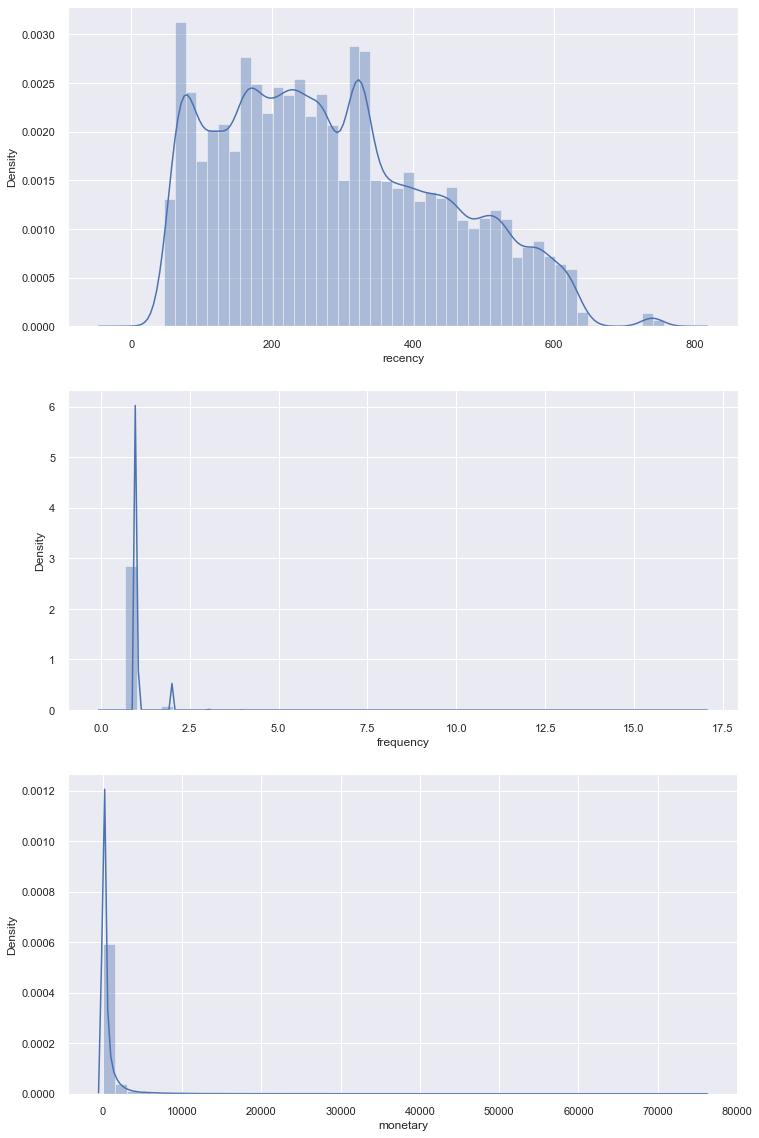

In [36]:
# Plot RFM distributions
plt.figure(figsize=(12,20))

# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm_df['recency'])

# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm_df['frequency'])

# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm_df['monetary'])
# Show the plot

plt.show()

Il n'y a pas de valeurs aberrantes pour la Récence mais pour la Fréquence et le Monétaire il y a des valeurs aberrantes.

#### 4.8.1. Outliers

<AxesSubplot:xlabel='recency'>

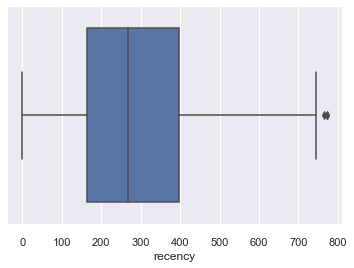

In [37]:
sns.boxplot(rfm_df['recency'])

<AxesSubplot:xlabel='frequency'>

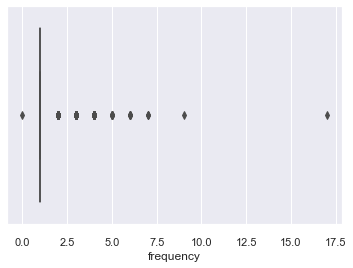

In [38]:
sns.boxplot(rfm_df['frequency'])

<AxesSubplot:xlabel='monetary'>

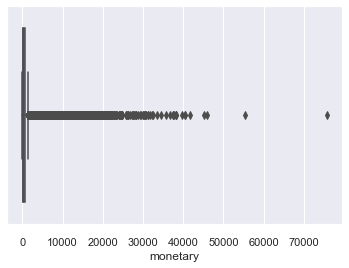

In [39]:
sns.boxplot(rfm_df['monetary'])

Cela confirme qu'il y a des outliers pour la Fréquence et la Monaitaire

#### 4.8.1.1. Suppression des outliers

In [40]:
# outlier treatment for monetary
Q1 = rfm_df.monetary.quantile(0.05)
Q3 = rfm_df.monetary.quantile(0.95)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.monetary >= Q1 - 1.5*IQR) & (rfm_df.monetary <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = rfm_df.frequency.quantile(0.05)
Q3 = rfm_df.frequency.quantile(0.95)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.frequency >= Q1 - 1.5*IQR) & (rfm_df.frequency <= Q3 + 1.5*IQR)]

<AxesSubplot:xlabel='monetary'>

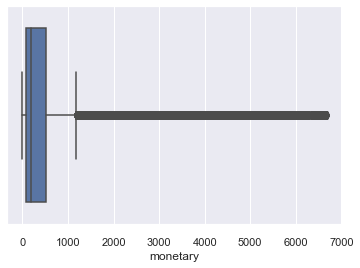

In [41]:
sns.boxplot(rfm_df['monetary'])

<AxesSubplot:xlabel='frequency'>

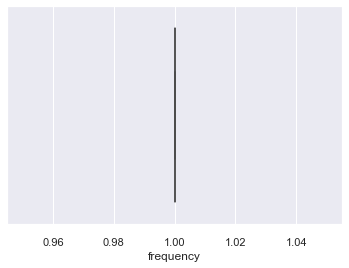

In [42]:
sns.boxplot(rfm_df['frequency'])

On gardera les outliers qui reste de la variables monitary , et pour la varible fréquancy on remarque qu'elle est toujour égale à 1.

#### 4.8.2. Standardisation

La standardiation de cette base de données sera fait avec StandardScaler.

In [43]:
rfm_df_scaled = rfm_df[['monetary', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df_scaled)
rfm_df_scaled.shape

(91843, 3)

In [44]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['monetary', 'frequency', 'recency']
rfm_df_scaled.head()

,monetary,frequency,recency
0,0.736085,0.0,-0.835414
1,-0.556303,0.0,-0.815870
2,0.216522,0.0,1.933299
3,-0.384503,0.0,0.526141
4,0.789903,0.0,0.311159


## 5. Modélisation K-Means Clustering

In [45]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [46]:
kmeans.labels_

array([1, 1, 3, ..., 3, 1, 3])

### 5.1 Nombre optimal de clusters

Le nombre optimal de clusters entre les chiffres 2 et 15.

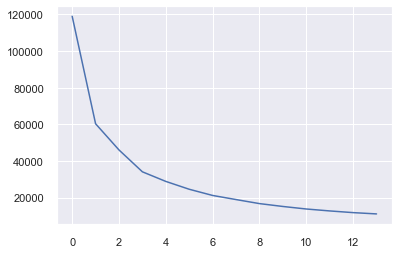

In [47]:
# elbow-curve/Sum of Squard Distance
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

Le nombre de cluster optimal est de 3 pour K-Means.

### 5.2. Silhouette Analysis

#### 5.2.1. Importation des librairies

In [48]:
from datetime import datetime
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from scipy import stats
import datetime
import os
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import squarify
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
from yellowbrick.cluster import KElbowVisualizer
import matplotlib as mpl
import seaborn as sns; sns.set()
from sklearn.cluster import MeanShift, estimate_bandwidth
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#### 5.2.2. CLustering avec  Silhouette analysis

In [49]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.4396119570148116
For n_clusters=3, the silhouette score is 0.4896245912341337
For n_clusters=4, the silhouette score is 0.425079302589801
For n_clusters=5, the silhouette score is 0.44787026473200653
For n_clusters=6, the silhouette score is 0.4583323047735486
For n_clusters=7, the silhouette score is 0.4094896231833338
For n_clusters=8, the silhouette score is 0.4193986534278842
For n_clusters=9, the silhouette score is 0.397676857663619
For n_clusters=10, the silhouette score is 0.40718473568241653
For n_clusters=11, the silhouette score is 0.4153001784845791
For n_clusters=12, the silhouette score is 0.4187051775376085
For n_clusters=13, the silhouette score is 0.39603572521502317
For n_clusters=14, the silhouette score is 0.4001250035284875
For n_clusters=15, the silhouette score is 0.4023050648527952


Ainsi, à l’aide  de silhouette scores , on conclut que le nombre optimal de clusters  est de 3. Cela confirme le nombre de clusters trouver avec K-means.

Mais nous allons utilisé pour la suis quatre clusters pour notre problème métier car nous classerons les clients en quttre groupe diamant, or, argent et bronze.

In [50]:
# m k=4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)
kmeans.labels_

array([0, 0, 1, ..., 1, 0, 1])

#### 5.2.3. Attribution d'une étiquette

In [51]:
# assign the label
rfm_df['cluster_id'] = kmeans.labels_
rfm_df.head()

,customer_unique_id,monetary,frequency,recency,cluster_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1,160.0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163.0,0
2,0000f46a3911fa3c0805444483337064,689.76,1,585.0,1
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1,369.0,2
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1,336.0,2


#### 5.2.4. Box plot

##### 5.2.4.1. Monetary box plot

<AxesSubplot:xlabel='cluster_id', ylabel='monetary'>

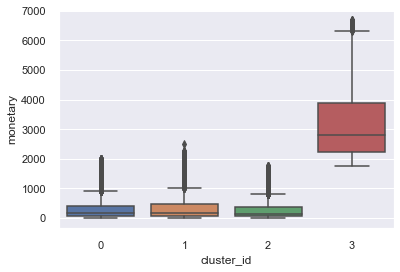

In [53]:
# box plot
sns.boxplot(x='cluster_id', y='monetary', data=rfm_df)

Les clients du cluster 3 sont ceux qui dépensent le plus.

##### 5.2.4.2. Recency box plot

<AxesSubplot:xlabel='cluster_id', ylabel='recency'>

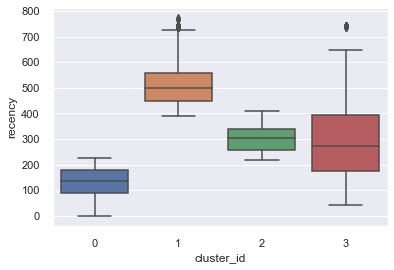

In [54]:
# box plot
sns.boxplot(x='cluster_id', y='recency', data=rfm_df)

Ce sont les client du clusters 0 qui ont fait des achats le plus récement.

##### 5.2.4.3. Frequency box plot

<AxesSubplot:xlabel='cluster_id', ylabel='frequency'>

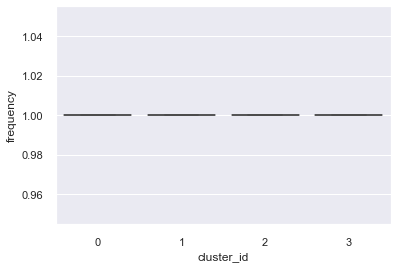

In [55]:
# box plot
sns.boxplot(x='cluster_id', y='frequency', data=rfm_df)

La fréquence d'achat est la même pour chaque clusters.

## 6. Classification ascendante hiérarchique

### 6.1. Importation des librairies

In [56]:
from collections import Counter, defaultdict
from sklearn.cluster import DBSCAN
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc

#### 6.2. Les variables numériques

In [57]:
numerical_features = list(df_train.select_dtypes(include=['int64','float64']).columns)
numerical_features

['order_item_id',
 'price',
 'freight_value',
 'payment_sequential_x',
 'payment_installments_x',
 'payment_value_x',
 'payment_sequential_y',
 'payment_installments_y',
 'payment_value_y',
 'review_score',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'customer_zip_code_prefix',
 'seller_zip_code_prefix',
 'price_log',
 'total_payment',
 'diff_days']

### 6.3. Création du dataframe de variables catégorielles

In [58]:
data_categories_col = df_train.drop(numerical_features  ,axis = 1)

### 6.4. Création du dataframe de variables numériques

In [59]:
data_bis = df_train.drop(data_categories_col, axis = 1)

#### 6.4.1 Standardisation 

In [60]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, data_bis)])

#### 6.4.2. Dataframe de variables numériques

In [61]:
X = data_bis.copy()
X.head(10)

,order_item_id,price,freight_value,payment_sequential_x,payment_installments_x,payment_value_x,payment_sequential_y,payment_installments_y,payment_value_y,review_score,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_zip_code_prefix,seller_zip_code_prefix,price_log,total_payment,diff_days
0,1.0,29.99,8.72,1.0,1.0,18.12,1.0,1.0,18.12,4.0,...,4.0,500.0,19.0,8.0,13.0,3149.0,9350.0,3.449670,18.12,380.0
9,1.0,29.99,7.78,1.0,3.0,37.77,1.0,3.0,37.77,4.0,...,4.0,500.0,19.0,8.0,13.0,3366.0,9350.0,3.449670,113.31,427.0
10,1.0,29.99,7.78,1.0,1.0,37.77,1.0,1.0,37.77,5.0,...,4.0,500.0,19.0,8.0,13.0,2290.0,9350.0,3.449670,37.77,440.0
11,1.0,29.99,14.10,1.0,1.0,44.09,1.0,1.0,44.09,3.0,...,4.0,500.0,19.0,8.0,13.0,88032.0,9350.0,3.449670,44.09,358.0
12,1.0,75.90,7.79,1.0,1.0,83.69,1.0,1.0,83.69,5.0,...,3.0,238.0,20.0,10.0,15.0,8577.0,9350.0,4.348987,83.69,433.0
13,1.0,75.90,7.79,1.0,2.0,83.69,1.0,2.0,83.69,4.0,...,3.0,238.0,20.0,10.0,15.0,13060.0,9350.0,4.348987,167.38,428.0
14,1.0,75.90,14.28,1.0,1.0,90.18,1.0,1.0,90.18,5.0,...,3.0,238.0,20.0,10.0,15.0,82030.0,9350.0,4.348987,90.18,442.0
15,1.0,75.90,7.79,1.0,2.0,83.69,1.0,2.0,83.69,2.0,...,3.0,238.0,20.0,10.0,15.0,13092.0,9350.0,4.348987,167.38,433.0
16,1.0,75.90,14.28,1.0,1.0,90.18,1.0,1.0,90.18,5.0,...,3.0,238.0,20.0,10.0,15.0,21340.0,9350.0,4.348987,90.18,435.0
17,1.0,44.99,7.78,1.0,2.0,52.77,1.0,2.0,52.77,4.0,...,2.0,1850.0,34.0,5.0,34.0,13820.0,9350.0,3.839237,105.54,462.0


#### 6.4.3. Suppression des 'NaN' et '0'

In [62]:
index_with_nan = X.index[X.isnull().any(axis=1)]

In [63]:
X.drop(index_with_nan,0, inplace=True)

In [64]:
X.head(10)

,order_item_id,price,freight_value,payment_sequential_x,payment_installments_x,payment_value_x,payment_sequential_y,payment_installments_y,payment_value_y,review_score,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_zip_code_prefix,seller_zip_code_prefix,price_log,total_payment,diff_days
0,1.0,29.99,8.72,1.0,1.0,18.12,1.0,1.0,18.12,4.0,...,4.0,500.0,19.0,8.0,13.0,3149.0,9350.0,3.449670,18.12,380.0
9,1.0,29.99,7.78,1.0,3.0,37.77,1.0,3.0,37.77,4.0,...,4.0,500.0,19.0,8.0,13.0,3366.0,9350.0,3.449670,113.31,427.0
10,1.0,29.99,7.78,1.0,1.0,37.77,1.0,1.0,37.77,5.0,...,4.0,500.0,19.0,8.0,13.0,2290.0,9350.0,3.449670,37.77,440.0
11,1.0,29.99,14.10,1.0,1.0,44.09,1.0,1.0,44.09,3.0,...,4.0,500.0,19.0,8.0,13.0,88032.0,9350.0,3.449670,44.09,358.0
12,1.0,75.90,7.79,1.0,1.0,83.69,1.0,1.0,83.69,5.0,...,3.0,238.0,20.0,10.0,15.0,8577.0,9350.0,4.348987,83.69,433.0
13,1.0,75.90,7.79,1.0,2.0,83.69,1.0,2.0,83.69,4.0,...,3.0,238.0,20.0,10.0,15.0,13060.0,9350.0,4.348987,167.38,428.0
14,1.0,75.90,14.28,1.0,1.0,90.18,1.0,1.0,90.18,5.0,...,3.0,238.0,20.0,10.0,15.0,82030.0,9350.0,4.348987,90.18,442.0
15,1.0,75.90,7.79,1.0,2.0,83.69,1.0,2.0,83.69,2.0,...,3.0,238.0,20.0,10.0,15.0,13092.0,9350.0,4.348987,167.38,433.0
16,1.0,75.90,14.28,1.0,1.0,90.18,1.0,1.0,90.18,5.0,...,3.0,238.0,20.0,10.0,15.0,21340.0,9350.0,4.348987,90.18,435.0
17,1.0,44.99,7.78,1.0,2.0,52.77,1.0,2.0,52.77,4.0,...,2.0,1850.0,34.0,5.0,34.0,13820.0,9350.0,3.839237,105.54,462.0


### 6.5. Preprocessing 

In [65]:
# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
  
# Normalizing the data so that 
# the data approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)
  
# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)

### 6.6. Analyse en composantes principales

In [66]:
# Explained variance
pca = PCA()
pca.fit(X_normalized)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[1.87704313e-01 9.78255491e-02 8.60163108e-02 8.42646283e-02
 8.18978523e-02 7.07604877e-02 6.85689464e-02 6.32009557e-02
 5.71802649e-02 4.91269880e-02 4.25481849e-02 2.28794000e-02
 2.09656045e-02 1.37463193e-02 1.25217357e-02 1.14631323e-02
 1.06587433e-02 2.11537217e-03 1.58088969e-03 2.46513553e-31
 6.19673039e-33 5.47183254e-33]
[1.90557787e-01 9.93126893e-02 8.73239274e-02 8.55456159e-02
 8.31428603e-02 7.18361858e-02 6.96113288e-02 6.41617341e-02
 5.80495170e-02 4.98738145e-02 4.31950008e-02 2.32272117e-02
 2.12843228e-02 1.39552903e-02 1.27120907e-02 1.16373944e-02
 1.08207771e-02 2.14752997e-03 1.60492232e-03 2.50261042e-31
 6.29093285e-33 5.55501513e-33]


##### 6.6.1 Nombre de variables pour 90% de la variance

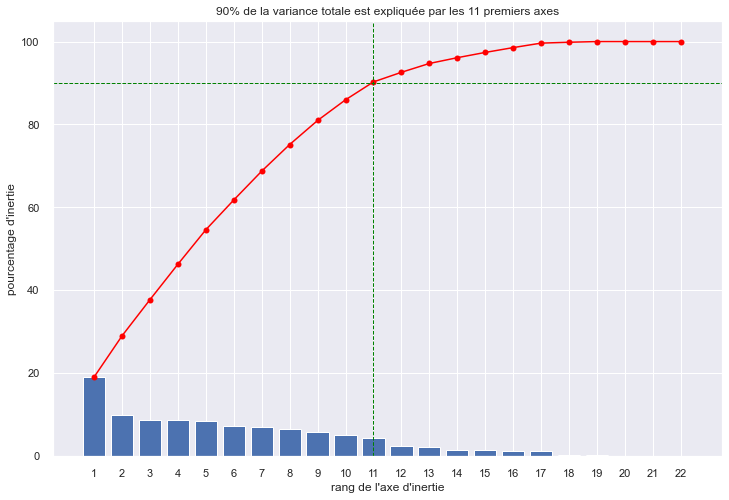

In [67]:
# Explained variance
pca = PCA()
pca.fit(X_normalized)
varexpl = pca.explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=90, linestyle="--", 
            color="green",
            linewidth=1)

limit = 90
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,min_plans))
plt.show(block=False)

90% de la variance est expliquée  par les 11 premières variables.

##### 6.6.2. Réduction de la dimensionnalité du Dataframe 

In [68]:
# Réduire la dimensionnalité des Données
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

##### 6.6.3. Divison du Dataframe en données d'entrainement et données de test

In [69]:
 X_train, X_test,  = train_test_split(
                     X_principal,  test_size=0.8, random_state=0)

### 6.7. Dendogramme

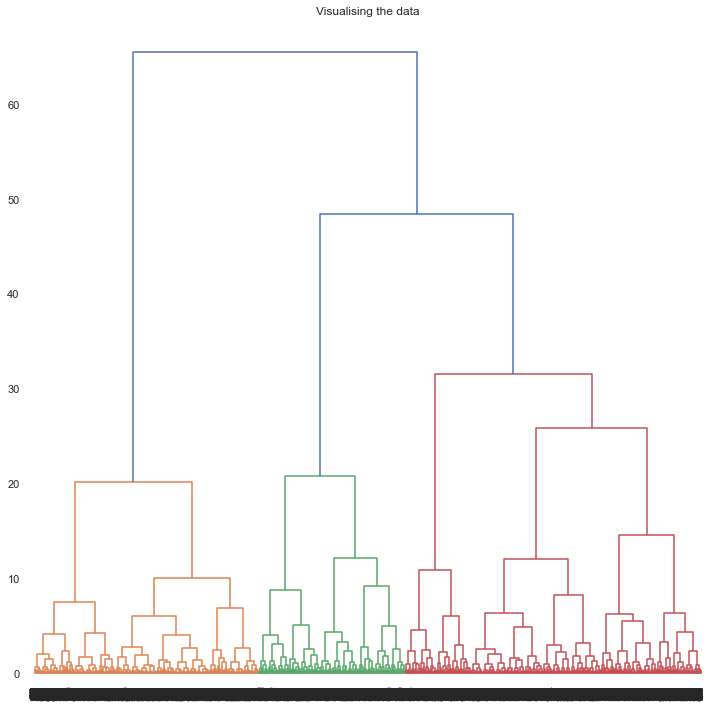

In [70]:
# Dendograms are used to divide a given cluster into many different clusters.

# Visualizing the working of the Dendograms

plt.figure(figsize =(12, 12))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_train, method ='ward')))

Ce dendrogramme  montre que le nombre optimal de clusters est de 3.

### 6.8. Le y_train le y_test

In [71]:
y_train, y_test,  = train_test_split(
                     X_principal,  test_size=0.2, random_state=0)

###  6.9. Création et visualisation des différents modèles de clustering pour différentes valeurs de k

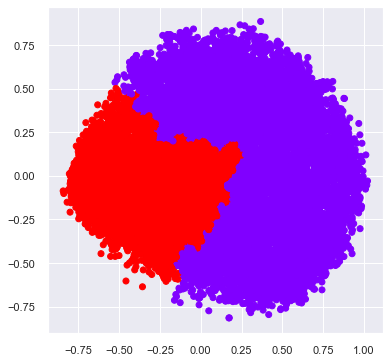

In [72]:
# k = 2

ac2 = AgglomerativeClustering(n_clusters = 2)
  
# Visualizing the clustering
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac2.fit_predict(y_test), cmap ='rainbow')
plt.show()

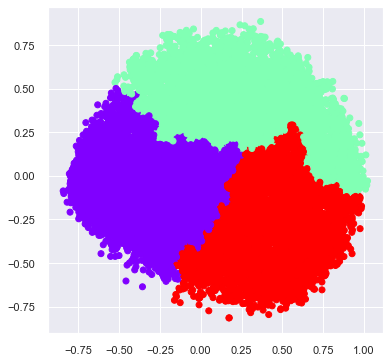

In [73]:
# k = 3

ac3 = AgglomerativeClustering(n_clusters = 3)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac3.fit_predict(y_test), cmap ='rainbow')
plt.show()

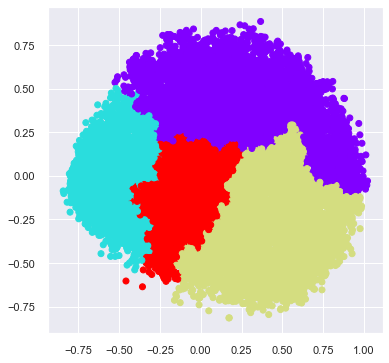

In [74]:
# k = 4

ac4 = AgglomerativeClustering(n_clusters = 4)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac4.fit_predict(y_test), cmap ='rainbow')
plt.show()

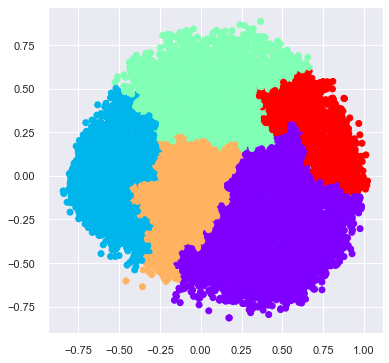

In [75]:
# k = 5

ac5 = AgglomerativeClustering(n_clusters = 5)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac5.fit_predict(y_test), cmap ='rainbow')
plt.show()

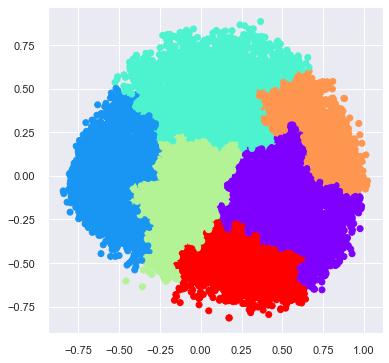

In [76]:
# k = 6

ac6 = AgglomerativeClustering(n_clusters = 6)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac6.fit_predict(y_test), cmap ='rainbow')
plt.show()

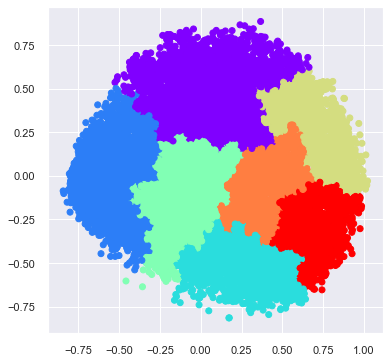

In [77]:
# k = 7

ac7 = AgglomerativeClustering(n_clusters = 7)
  
plt.figure(figsize =(6, 6))
plt.scatter(y_test['P1'], y_test['P2'],
            c = ac7.fit_predict(y_test), cmap ='rainbow')
plt.show()


Nous déterminons maintenant le nombre optimal de clusters à l’aide d’une technique mathématique. Ici, nous utiliserons les scores de silhouette à cette fin.


In [78]:
# Evaluating the different models and Visualizing the results.

# Appending the silhouette scores of the different models to the list
silhouette_scores = []
silhouette_scores.append(
        silhouette_score(y_test, ac2.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac3.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac4.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac5.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac6.fit_predict(y_test)))
silhouette_scores.append(
        silhouette_score(y_test, ac7.fit_predict(y_test)))

#### 6.9.  Comparaison des résultats

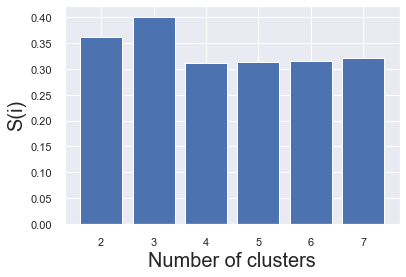

In [79]:
# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6, 7]
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

Avec des scores de silhouette, on conclut que le nombre optimal de clusters pour les données est de 3.

## 7. Modélisation DBSCAN Clustering

On realisera une modélisation DBSCAN avec et sans PCA pour l'interêt de ce dernier.

### 7.1. Modélisation DBSCAN Clustering avec PCA

In [80]:
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 0.025, min_samples = 100).fit(X_principal)
labels = db_default.labels_

In [81]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

In [82]:
# Building the clustering model

labels_true = X.index

# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 0.025, min_samples = 5).fit(X_principal)
core_samples_mask = np.zeros_like(db_default.labels_, dtype=bool)
core_samples_mask[db_default.core_sample_indices_] = True
labels = db_default.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.4f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.4f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.4f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.4f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.4f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.4f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 80
Homogeneity: 0.0007
Completeness: 1.0000
V-measure: 0.0015
Adjusted Rand Index: 0.0000
Adjusted Mutual Information: -0.0000
Silhouette Coefficient: -0.3817


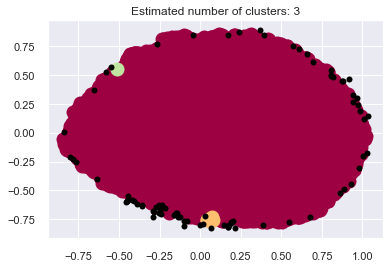

In [83]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_principal[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_principal[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### 7.2. Modélisation DBSCAN Clustering sans PCA

In [84]:
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 0.405, min_samples = 100).fit(X_normalized)
labels = db_default.labels_

In [85]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int64)

In [86]:
# Building the clustering model

labels_true = X.index
# Numpy array of all the cluster labels assigned to each data point
db_default = DBSCAN(eps = 0.405, min_samples = 5).fit(X_normalized)
core_samples_mask = np.zeros_like(db_default.labels_, dtype=bool)
core_samples_mask[db_default.core_sample_indices_] = True
labels = db_default.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.4f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.4f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.4f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.4f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.4f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.4f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 163
Estimated number of noise points: 13472
Homogeneity: 0.0591
Completeness: 1.0000
V-measure: 0.1116
Adjusted Rand Index: 0.0000
Adjusted Mutual Information: -0.0000
Silhouette Coefficient: -0.8349


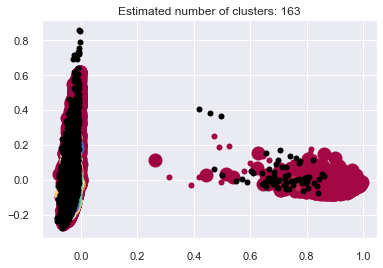

In [87]:
# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_normalized[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_normalized[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

En conclusion  la PCA est nécessaire pour un bon modèle. On a partitionné notre dataset clients en utilisant diffents algorithmes K-Means et DBSCAN avec PCA. Lles resultats tournent autour de 2 a 3 clusters, mais on choisira 4 clusters ce nombre de clusters car plus adapter à notre problème métier.

## 8. La segmentation

### 8.1. Importation des librairies

In [88]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import cluster, metrics, decomposition, preprocessing
import plotly.io as pio
pio.renderers.default='notebook'
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import seaborn as sns
from time import process_time
import math
from math import * 
from sklearn.metrics import adjusted_rand_score
import plotly.io as pio
pio.renderers.default = 'iframe'
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.contrib.scatter import ScatterVisualizer
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px

### 8.2. Dataframe

In [89]:
rfm_df.shape

(91843, 5)

In [90]:
rfm_df.head()

,customer_unique_id,monetary,frequency,recency,cluster_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1,160.0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163.0,0
2,0000f46a3911fa3c0805444483337064,689.76,1,585.0,1
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1,369.0,2
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1,336.0,2


### 8.3. Prédiction RFM

In [91]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_df[['recency']])
rfm_df['R'] = kmeans.predict(rfm_df[['recency']])
rfm_df

,customer_unique_id,monetary,frequency,recency,cluster_id,R
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1,160.0,0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163.0,0,1
2,0000f46a3911fa3c0805444483337064,689.76,1,585.0,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1,369.0,2,0
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1,336.0,2,0
...,...,...,...,...,...,...
96090,fffcc512b7dfecaffd80f13614af1d16,2132.10,1,189.0,3,3
96092,fffea47cd6d3cc0a88bd621562a9d061,84.58,1,310.0,2,0
96093,ffff371b4d645b6ecea244b27531430a,112.46,1,617.0,1,2
96094,ffff5962728ec6157033ef9805bacc48,668.45,1,168.0,0,1


In [92]:
kmeans_frequency = KMeans(n_clusters=4)
kmeans_frequency.fit(rfm_df[['frequency']])
rfm_df['F'] = kmeans_frequency.predict(rfm_df[['frequency']])
rfm_df

,customer_unique_id,monetary,frequency,recency,cluster_id,R,F
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1,160.0,0,1,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163.0,0,1,0
2,0000f46a3911fa3c0805444483337064,689.76,1,585.0,1,2,0
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1,369.0,2,0,0
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1,336.0,2,0,0
...,...,...,...,...,...,...,...
96090,fffcc512b7dfecaffd80f13614af1d16,2132.10,1,189.0,3,3,0
96092,fffea47cd6d3cc0a88bd621562a9d061,84.58,1,310.0,2,0,0
96093,ffff371b4d645b6ecea244b27531430a,112.46,1,617.0,1,2,0
96094,ffff5962728ec6157033ef9805bacc48,668.45,1,168.0,0,1,0


In [93]:
kmeans_revenue = KMeans(n_clusters=4)
kmeans_revenue.fit(rfm_df[['monetary']])
rfm_df['M'] = kmeans_revenue.predict(rfm_df[['monetary']])
rfm_df

,customer_unique_id,monetary,frequency,recency,cluster_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1,160.0,0,1,0,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163.0,0,1,0,0
2,0000f46a3911fa3c0805444483337064,689.76,1,585.0,1,2,0,3
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1,369.0,2,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1,336.0,2,0,0,3
...,...,...,...,...,...,...,...,...
96090,fffcc512b7dfecaffd80f13614af1d16,2132.10,1,189.0,3,3,0,2
96092,fffea47cd6d3cc0a88bd621562a9d061,84.58,1,310.0,2,0,0,0
96093,ffff371b4d645b6ecea244b27531430a,112.46,1,617.0,1,2,0,0
96094,ffff5962728ec6157033ef9805bacc48,668.45,1,168.0,0,1,0,3


### 8.4. Monetary describe

In [94]:
rfm_df.groupby('M')['monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
M,,,,,,,,
0,71827.0,173.038311,144.281941,0.0,61.85,118.56,248.44,597.76
1,1642.0,4912.710658,857.701826,3683.5,4158.90,4782.85,5562.30,6680.40
2,4905.0,2456.495937,534.885715,1739.2,1984.80,2351.84,2839.20,3682.00
3,13469.0,1021.312054,312.485929,597.9,757.32,942.80,1256.25,1738.40


### 8.5. RFM

In [95]:
rfm = rfm_df[['recency','frequency','monetary']]
rfm

,recency,frequency,monetary
0,160.0,1,1135.20
1,163.0,1,27.19
2,585.0,1,689.76
3,369.0,1,174.48
4,336.0,1,1181.34
...,...,...,...
96090,189.0,1,2132.10
96092,310.0,1,84.58
96093,617.0,1,112.46
96094,168.0,1,668.45


Nous transformons la valeur RFM en une échelle logarithmique

In [96]:
# appliquer une transformation logarithmique pour obtenir la même échelle
rfm_log = np.log(rfm)

Nous remplaçons la valeur 0 pour éviter d’obtenir des valeurs infinies après avoir utilisé une transformation logarithmique.

In [97]:
rfm_log = rfm_log.replace([np.inf, -np.inf], 0)
rfm_log = pd.DataFrame(data = rfm_log, 
                            index = rfm_df.index, 
                            ) 
rfm_log

,recency,frequency,monetary
0,5.075174,0.0,7.034564
1,5.093750,0.0,3.302849
2,6.371612,0.0,6.536344
3,5.910797,0.0,5.161810
4,5.817111,0.0,7.074405
...,...,...,...
96090,5.241747,0.0,7.664863
96092,5.736572,0.0,4.437698
96093,6.424869,0.0,4.722598
96094,5.123964,0.0,6.504962


### 8.6. Standarisation

Nous utilisons StandardScaler() pour standardiser les données avant d’utiliser une méthode de clustering sur les trois variables RFM afin d’obtenir notre cluster final de clients.

In [98]:
scaler = StandardScaler()
rfm_standard = scaler.fit_transform(rfm_log)

Créer un e dataframe prête pour le clustering

In [99]:
rfm_standard = pd.DataFrame(data = rfm_standard, 
                            index = rfm_df.index, 
                            ) 
rfm_standard.columns = ['recency','frequency','monetary']
rfm_standard

,recency,frequency,monetary
0,-0.672064,0.0,1.293680
1,-0.642253,0.0,-1.521502
2,1.408435,0.0,0.917825
3,0.668928,0.0,-0.119114
4,0.518583,0.0,1.323735
...,...,...,...
96090,-0.404751,0.0,1.769173
96092,0.389336,0.0,-0.665380
96093,1.493901,0.0,-0.450453
96094,-0.593767,0.0,0.894151


### 8.7. RFM CLusters

In [100]:
kmeans_cluster = KMeans(n_clusters=4)
kmeans_cluster.fit(rfm_standard)
rfm_standard['RFM Clusters'] = kmeans_cluster.predict(rfm_standard)
rfm_standard

,recency,frequency,monetary,RFM Clusters
0,-0.672064,0.0,1.293680,2
1,-0.642253,0.0,-1.521502,1
2,1.408435,0.0,0.917825,0
3,0.668928,0.0,-0.119114,3
4,0.518583,0.0,1.323735,0
...,...,...,...,...
96090,-0.404751,0.0,1.769173,2
96092,0.389336,0.0,-0.665380,3
96093,1.493901,0.0,-0.450453,3
96094,-0.593767,0.0,0.894151,2


In [101]:
rfm_standard_s = rfm_standard.rename(columns = {'recency':'recency_s','frequency':'frequency_s','monetary':'monetary_s'})

In [102]:
df_user = pd.concat([rfm_df, rfm_standard_s], axis=1)
df_user

,customer_unique_id,monetary,frequency,recency,cluster_id,R,F,M,recency_s,frequency_s,monetary_s,RFM Clusters
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1,160.0,0,1,0,3,-0.672064,0.0,1.293680,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163.0,0,1,0,0,-0.642253,0.0,-1.521502,1
2,0000f46a3911fa3c0805444483337064,689.76,1,585.0,1,2,0,3,1.408435,0.0,0.917825,0
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1,369.0,2,0,0,0,0.668928,0.0,-0.119114,3
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1,336.0,2,0,0,3,0.518583,0.0,1.323735,0
...,...,...,...,...,...,...,...,...,...,...,...,...
96090,fffcc512b7dfecaffd80f13614af1d16,2132.10,1,189.0,3,3,0,2,-0.404751,0.0,1.769173,2
96092,fffea47cd6d3cc0a88bd621562a9d061,84.58,1,310.0,2,0,0,0,0.389336,0.0,-0.665380,3
96093,ffff371b4d645b6ecea244b27531430a,112.46,1,617.0,1,2,0,0,1.493901,0.0,-0.450453,3
96094,ffff5962728ec6157033ef9805bacc48,668.45,1,168.0,0,1,0,3,-0.593767,0.0,0.894151,2


In [103]:
customer_segments = df_user.groupby('RFM Clusters')[
    'recency_s','frequency_s','monetary_s'].mean()
customer_segments.sort_values(by=['frequency_s'], ascending=False)
customer_segments.sort_values(by=['monetary_s'], ascending=False)

,recency_s,frequency_s,monetary_s
RFM Clusters,,,
0,0.648640,0.0,0.993785
2,-1.079825,0.0,0.946343
3,0.583652,0.0,-0.684788
1,-1.187044,0.0,-0.707643


In [104]:
rfm_df.loc[df_user['RFM Clusters'] == 0,'Segment'] = 'Bronze'
rfm_df.loc[df_user['RFM Clusters'] == 2,'Segment'] = 'Silver' 
rfm_df.loc[df_user['RFM Clusters'] == 3,'Segment'] = 'Gold' 
rfm_df.loc[df_user['RFM Clusters'] == 1,'Segment'] = 'Diamond'

In [105]:
segments_counts = rfm_df ['Segment'].value_counts().sort_values(ascending=True)
segments_counts

Silver     13934
Diamond    18070
Bronze     24174
Gold       35665
Name: Segment, dtype: int64

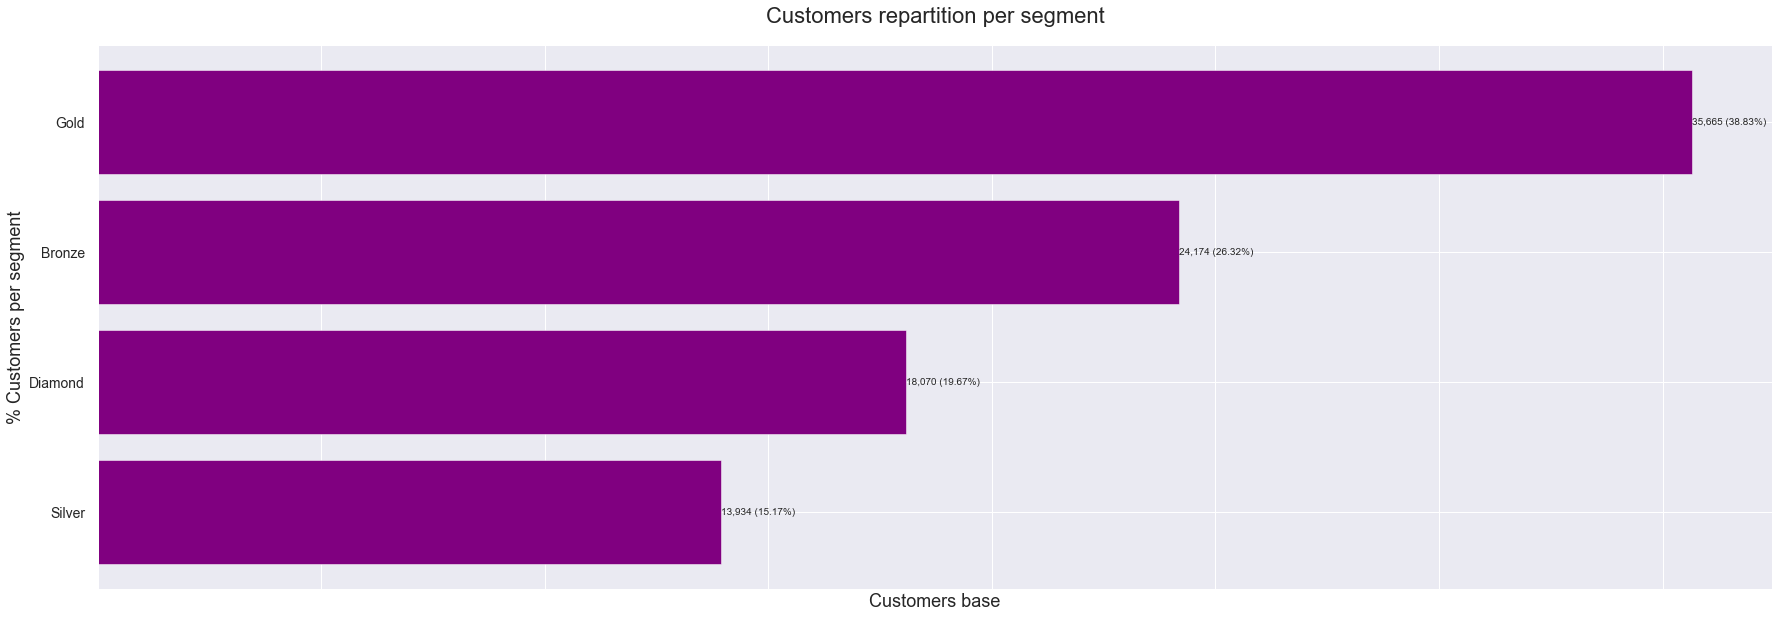

In [106]:
plt.style.use('ggplot')
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(30, 10))
bars = ax.barh(range(len(segments_counts)), segments_counts, color='purple')
plt.title("Customers repartition per segment", size=22, y=1.03)
plt.xlabel("Customers base", size=18)
plt.ylabel("% Customers per segment", size=18)
ax.tick_params(left=False, bottom=False, labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index,  fontsize = 14)

for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,bar.get_y() + bar.get_height()/2,'{:,} ({:,.2f}%)'.format(int(value),
                float(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
        
# don't crop the legend while saving the figure
plt.savefig('count_segmentation.png', dpi=300, format='png', bbox_inches='tight') 
plt.show()

La répatition des clients est pour Gold de 38.83%, pour Bronze de 26.32%, pour Diamond de 19.67 et enfin pour Silver 15,71.

## 9. Stabilité temporelle de la segmentation

### 9.1. Importation des librairies

In [107]:
from datetime import date
from dateutil.relativedelta import relativedelta

### 9.2. Dataframe 

In [108]:
df_user

,customer_unique_id,monetary,frequency,recency,cluster_id,R,F,M,recency_s,frequency_s,monetary_s,RFM Clusters
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1,160.0,0,1,0,3,-0.672064,0.0,1.293680,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163.0,0,1,0,0,-0.642253,0.0,-1.521502,1
2,0000f46a3911fa3c0805444483337064,689.76,1,585.0,1,2,0,3,1.408435,0.0,0.917825,0
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1,369.0,2,0,0,0,0.668928,0.0,-0.119114,3
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1,336.0,2,0,0,3,0.518583,0.0,1.323735,0
...,...,...,...,...,...,...,...,...,...,...,...,...
96090,fffcc512b7dfecaffd80f13614af1d16,2132.10,1,189.0,3,3,0,2,-0.404751,0.0,1.769173,2
96092,fffea47cd6d3cc0a88bd621562a9d061,84.58,1,310.0,2,0,0,0,0.389336,0.0,-0.665380,3
96093,ffff371b4d645b6ecea244b27531430a,112.46,1,617.0,1,2,0,0,1.493901,0.0,-0.450453,3
96094,ffff5962728ec6157033ef9805bacc48,668.45,1,168.0,0,1,0,3,-0.593767,0.0,0.894151,2


In [109]:
df_train['order_purchase_timestamp (string)'] = pd.to_datetime(
    df_train['order_purchase_timestamp'])

#### 9.2.1. customer_unique_id

In [110]:
df_costum = pd.DataFrame(df_train['customer_unique_id'])
# rfm_df.columns = ['CustomerUniqueID']
df_costum

,customer_unique_id
0,7c396fd4830fd04220f754e42b4e5bff
9,3a51803cc0d012c3b5dc8b7528cb05f7
10,ef0996a1a279c26e7ecbd737be23d235
11,e781fdcc107d13d865fc7698711cc572
12,02c9e0c05a817d4562ec0e8c90f29dba
...,...
141527,2077f7ec37df79c62cc24b7b8f30e8c9
141528,78a159045124eb7601951b917a42034f
141529,8cf3c6e1d2c8afaab2eda3fa01d4e3d2
141530,e55e436481078787e32349cee9febf5e


#### 9.3.2. Fusion de  customer_unique_id avec order_purchase_timestamp

In [111]:
max_purchase = df_train.groupby('customer_unique_id')[
    'order_purchase_timestamp'].max().reset_index()
# max_purchase.columns = ['CustomerUniqueID','MaxPurchaseDate']
max_purchase

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42
...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36
96092,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56
96093,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16
96094,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41


#### 9.3.3. Fusion du Dataframe et de order_purchase_timestamp

In [112]:
df_final = pd.merge(max_purchase, df_user, on='customer_unique_id', how='inner')
df_final.head()

,customer_unique_id,order_purchase_timestamp,monetary,frequency,recency,cluster_id,R,F,M,recency_s,frequency_s,monetary_s,RFM Clusters
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1135.20,1,160.0,0,1,0,3,-0.672064,0.0,1.293680,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,27.19,1,163.0,0,1,0,0,-0.642253,0.0,-1.521502,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,689.76,1,585.0,1,2,0,3,1.408435,0.0,0.917825,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,174.48,1,369.0,2,0,0,0,0.668928,0.0,-0.119114,3
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1181.34,1,336.0,2,0,0,3,0.518583,0.0,1.323735,0


In [113]:
df_final.dtypes.value_counts()

float64           5
int32             5
object            1
datetime64[ns]    1
int64             1
dtype: int64

#### 9.3.4. Filtrer le Datafram à la la date maximum du '2017-12-31 00:00:00'

In [114]:
filtered_df = df_final.loc[( df_final['order_purchase_timestamp'] < '2017-12-31 00:00:00')]

In [115]:
filtered_df

,customer_unique_id,order_purchase_timestamp,monetary,frequency,recency,cluster_id,R,F,M,recency_s,frequency_s,monetary_s,RFM Clusters
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,689.76,1,585.0,1,2,0,3,1.408435,0.0,0.917825,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,174.48,1,369.0,2,0,0,0,0.668928,0.0,-0.119114,3
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1181.34,1,336.0,2,0,0,3,0.518583,0.0,1.323735,0
8,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12,450.36,1,591.0,1,2,0,0,1.424811,0.0,0.596230,0
10,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18 09:23:10,58.00,1,456.0,1,2,0,0,1.008654,0.0,-0.949978,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91836,fffb09418989a0dbff854a28163e47c6,2017-12-17 19:14:35,73.16,1,303.0,2,0,0,0,0.352683,0.0,-0.774804,3
91837,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12-27 22:36:41,334.64,1,293.0,2,3,0,0,0.298826,0.0,0.372181,0
91839,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,84.58,1,310.0,2,0,0,0,0.389336,0.0,-0.665380,3
91840,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,112.46,1,617.0,1,2,0,0,1.493901,0.0,-0.450453,3


### 9.3. Dévision du Dataframe 

In [116]:
start_date = date(2018, 1, 1)
n_months = 8

# m = date(2018, 1, 31) + relativedelta(months=+1)
df_range = []

for i in range(n_months):
    current_date = start_date + relativedelta(months=+i)
    df_range.append(df_final.loc[( df_final[
        'order_purchase_timestamp'] < pd.to_datetime(current_date))])

In [117]:
for df in df_range:
    print(df.shape)

(41552, 13)
(48286, 13)
(54445, 13)
(61142, 13)
(67612, 13)
(74013, 13)
(79802, 13)
(85690, 13)


In [118]:
all_rfm = []

for i in range(n_months):
    all_rfm.append(df_range[i][['recency_s','frequency_s','monetary_s']])

In [119]:
for df in all_rfm:
    print(df.shape)

(41552, 3)
(48286, 3)
(54445, 3)
(61142, 3)
(67612, 3)
(74013, 3)
(79802, 3)
(85690, 3)


### 9.4. Création du modèle

In [120]:
models = []

for i in range(n_months):
    kmeans_cluster = KMeans(n_clusters=4, n_init=10, init='k-means++', max_iter=100)
    models.append(kmeans_cluster.fit(all_rfm[i]))

### 9.5. Comparaison avec ARI

L’indice rand calcule une mesure de similitude entre deux clusters en considérant toutes les paires d’échantillons et en comptant les paires qui sont affectées dans le même ou des clusters différents dans les clusters prédits et réels.

In [121]:
all_ari = []

for i in range(n_months):
    label1 = models[0].predict(all_rfm[i])
    label2 = models[i].predict(all_rfm[i])
    all_ari.append(adjusted_rand_score(label1, label2))

In [122]:
print(all_ari)

[1.0, 0.984205863955528, 0.3682698457188367, 0.41393258010474054, 0.33494417393777426, 0.30614853243738466, 0.27097427864443424, 0.33586383200217196]


In [123]:
d = {'ARI'}
list1 = all_ari
ari_table = pd.DataFrame(data = list1, columns=d)
ari_table

,ARI
0,1.000000
1,0.984206
2,0.368270
3,0.413933
4,0.334944
5,0.306149
6,0.270974
7,0.335864


<AxesSubplot:>

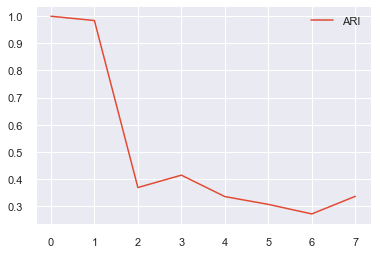

In [124]:
ari_table.plot.line()

### 9.6. Conclusion

Nous remarquons une une forte baisse au février 2018, donc nous recommandons à Olist de mettre à jour le modèle de clustering tout les deux mois pour un modèle précis.